# Objective of this Notebook
This notebook uses the dataset provided by kaggle for a competition called : Don't Overfit! II. 

Kagle provides a test set and a very small training set, which will encourage our model to overfit.

So we have to avoid overfitting and propose a model which can generalize to new examples coming from the test set.

## 1. Data Exploration

### Reading data

In [3]:
import pandas as pd
import os

In [4]:
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
training_set.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


### Features types

In [5]:
set(training_set.dtypes.values)

{dtype('int64'), dtype('float64')}

We only have numerical features, we can perform regression (linear or logistic)


### Missing values

In [6]:
training_set.isnull().any().any()

False

The False boolean tells us that we have no missing values.

### Target classes repartition

In [7]:
print(training_set['target'].value_counts(),'\n')

class0_total = training_set['target'].value_counts()[0]
class1_total = training_set['target'].value_counts()[1]
total =  class1_total + class0_total
print('Percentage of class 0:',(class0_total / total)*100, "%")
print('Percentage of class 1:',(class1_total / total)*100, "%")

0.0    183
1.0     67
Name: target, dtype: int64 

Percentage of class 0: 73.2 %
Percentage of class 1: 26.8 %


Given that the class 0 is much more present than the class 1, we are in an imbalanced case. 
Thus, later, when we'll evaluate our model, we should use an appropriate metric of evaluation for skewed classes.
We could use **precision**, **recall** and finally compute the **F1 score**

## 2. Data preprocessing
### Feature scaling
<a id='scaling-data'></a>

Our linear model uses Gradient Descent to minimize a cost function.
We can speed up gradient descent by having each of our input values in roughly the same range.
Two techniques to help with this are feature scaling and mean normalization. 

* Feature scaling involves dividing the input values by the range (i.e. the maximum value minus the minimum value) of the input variable, resulting in a new range of just 1. 

* Mean normalization involves subtracting the average value for an input variable from the values for that input variable resulting in a new average value for the input variable of just zero. 

-> To implement both of these techniques, we can adjust our input values as shown in this formula:
$Z = \frac{x - \mu}{\sigma}$ where x is the feature value, $\mu$ is the average of all the values for the feature concerned and $\sigma$ is the standard deviation (or the range value : max-min)


Here the features are transformed so that they have the properties of a standard normal distribution  with mean = 0 and standard deviation = 1.
This will speed up calcultations of algorithms using Gradient Descent and measures of distance (like Euclidean distance).

In [8]:
training_set.agg([min, max])

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
min,0,0.0,-3.181,-3.041,-2.967,-2.898,-2.837,-3.831,-2.873,-2.489,...,-2.824,-2.971,-3.592,-3.071,-2.621,-3.013,-3.275,-2.665,-3.006,-2.471
max,249,1.0,2.347,3.138,2.609,2.590,2.413,2.687,2.793,3.766,...,2.773,2.701,3.193,4.280,2.716,3.074,2.626,2.388,2.730,3.401


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Features column names without the target 'target' 
features_columns_names = training_set.columns[:-1]
scaled_data = scaler.fit_transform(training_set[features_columns_names])

#Replacing features old values with their scaled values
training_set.loc[:, features_columns_names] = scaled_data

## 3. Logistic Regression
### Model definition

In [12]:
from sklearn.model_selection import train_test_split 

training_targets = training_set['target']
training_predictors = training_set.drop(columns='target')

X_train, X_val, y_train, y_val = train_test_split(training_predictors, training_targets, test_size=0.30, random_state=42, shuffle=True, 
                                                    stratify=training_targets)

y_train = y_train.astype(int)
y_val =y_val.astype(int)


In [13]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model =LogisticRegression()

### Training, validation and evaluation

In [14]:
from sklearn.metrics import log_loss
import numpy as np

#To split the training set in 50 parts of same size
instance_sizes = np.linspace(0.05, 1.0, 50)
train_sizes = [int(i*X_train.shape[0]) for i in instance_sizes]

logloss_training_values = []
logloss_validation_values = []

for i in range(len(instance_sizes)):
    logistic_model = logistic_regression_model
        
    #Training part
    training_predictors = X_train.iloc[:train_sizes[i]]
    training_outputs = y_train.iloc[:train_sizes[i]]
    training_outputs = training_outputs.values.astype(int)
    
    logistic_model = logistic_model.fit(training_predictors , training_outputs)
    training_predictions = logistic_model.predict(training_predictors)
    logloss_training_values.append(log_loss(training_outputs,training_predictions))
        
        
    #Test on validation set part
    val_predictions = logistic_model.predict(X_val)
    val_outputs = y_val.values
    logloss_validation_values.append(log_loss(val_outputs, val_predictions))

### Learning curves 

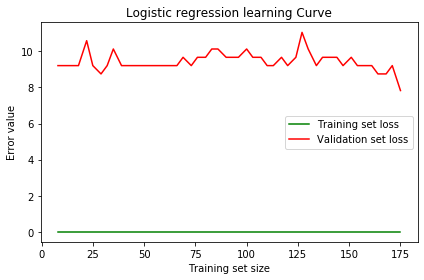

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

plt.plot(train_sizes,logloss_training_values, color="green", label="Training set loss")
plt.plot(train_sizes,logloss_validation_values, color="red",  label="Validation set loss")


# Create plot
plt.title("Logistic regression learning Curve")
plt.xlabel("Training set size"), plt.ylabel("Error value"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [17]:
print("Training F1-score:", f1_score(training_outputs, training_predictions))
print("Validation F1-score:", f1_score(val_outputs, val_predictions))

Training F1-score: 1.0
Validation F1-score: 0.41379310344827586


## 4. Results Interpretation

### Learning curve interpretation
Plotting learning curves could be a good way to check if our model is doing good.
The loss value is very close to 0 for the training set compared to the loss for the validation set.

### F1 scores interpretation
Given that the target classes are skewed (as seen on the 'Target classes repartition' part) , we'll use the F1 score , an appropriate metric when target classes proportions are imbalanced.

The relative contribution of precision and recall to the F1 score are equal. 

The formula for the F1 score is:
$$F1 = 2 * \frac{(precision * recall)}{(precision + recall)}$$

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its **best value at 1** and **worst score at 0**.


**The F1-score reaches its best value of 1.0 for the training set but reaches 0.41 for the validation set, which is much lower.**

### Conclusion of the interpretations
We can see that our model has a high variance of performance between the training set and the validation set.
**Our model is overfitting the training set and can't generalize to new examples coming from the validation set.**

### What can we do to reduce overfitting ?
To prevent or reduce overfitting there are several options for us:
* Use regularization techniques
* Feature selection : choose a smaller subset of features

## Feature Selection
### Pearson correlation between features
Pearson’s correlation coefficient is a statistical test which measures the statistical relationship, or association, between two continuous variables.  It is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

A Pearson correlation is a number between -1 and 1.
Features highly correlated (close to 1 or -1) with our target 'quality' will be helpful for the predictions of the latter.
If a feature has a correlation value close to 0, we can assume that they will be less useful regarding predictions of our target.

Let's analyze features correlation with our target to spot which features seems useful for prediction.

In [19]:
import seaborn as sns

correlations = training_set.corr()['target'].drop('target').abs().sort_values(ascending=False)
print(correlations,'\n\n')

127    0.337540
176    0.217100
18     0.206452
59     0.203166
135    0.179960
         ...   
108    0.001018
111    0.000971
246    0.000778
263    0.000624
269    0.000211
Name: target, Length: 301, dtype: float64 


